# Imports set up rendering

In [2]:
#@title Check if MuJoCo installation was successful

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
# %env MUJOCO_GL=egl
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true "
    "--xla_gpu_triton_gemm_any=True "
    # "--xla_gpu_enable_async_collectives=true "
    # "--xla_gpu_enable_latency_hiding_scheduler=true "
    # "--xla_gpu_enable_highest_priority_async_stream=true "
)
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 1
os.environ["XLA_FLAGS"] = (
    "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
)

Fri Oct 18 01:32:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.107.02             Driver Version: 550.107.02     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 30%   38C    P8             15W /  300W |      11MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
%load_ext autoreload
%autoreload 2
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Use GPU 1
import functools
import jax
# jax.config.update("jax_enable_x64", True)

n_gpus = jax.device_count(backend="gpu")
print(f"Using {n_gpus} GPUs")
from typing import Dict
from brax import envs
import mujoco
import pickle
import warnings
import mediapy as media
import hydra
import jax.numpy as jp

from omegaconf import DictConfig, OmegaConf
from brax.training.agents.ppo import networks as ppo_networks
from custom_brax import custom_ppo as ppo
from custom_brax import custom_wrappers
from custom_brax import custom_ppo_networks
from orbax import checkpoint as ocp
from flax.training import orbax_utils
from preprocessing.mjx_preprocess import process_clip_to_train
from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking
from utils.utils import *
from utils.fly_logging import log_eval_rollout

warnings.filterwarnings("ignore", category=DeprecationWarning)
# jax.config.update("jax_enable_x64", True)

from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra

##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'ps.fonttype':        42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'sans-serif',
                    #  'font.family':        'Arial',
                    #  'font.sans-serif':    'Arial',
                     'font.serif':         'Arial',
                    })

Using 1 GPUs


2024-10-18 01:32:10.209255: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/eabe/miniconda3/envs/stac-mjx-env/lib/python3.11/site-packages/wandb/analytics/sentry.py:90: SentryHubDeprecationWarning: `sentry_sdk.Hub` is deprecated and will be removed in a future major release. Please consult our 1.x to 2.x migration guide for details on how to migrate `Hub` usage to the new API: https://docs.sentry.io/platforms/python/migration/1.x-to-2.x
  self.hub = sentry_sdk.Hub(client)


# Load configs

In [4]:
dataset = "multiclip"
with initialize(version_base=None, config_path="configs"):
    cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

In [5]:
for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)
env_cfg = cfg.dataset
env_args = cfg.dataset.env_args
reference_path = cfg.paths.data_dir/ f"clips/all_clips_batch_interp.p"
# reference_path = cfg.paths.data_dir/ f"clips/0.p"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)


# Load env

In [12]:
dataset = 'multiclip'

from envs.Fly_Env_Brax import FlyTracking, FlyMultiClipTracking, FlyRunSim, _bounded_quat_dist
with initialize(version_base=None, config_path="configs"):
    cfg=compose(config_name='config.yaml',overrides= [f"dataset=fly_{dataset}", f"train=train_fly_{dataset}", "paths=walle"],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)
    
fig_dir = Path(cfg.paths.fig_dir)
env_args = cfg.dataset.env_args
print(cfg.train.env_name)
envs.register_environment("fly_freejnt_clip", FlyTracking)
envs.register_environment("fly_freejnt_multiclip", FlyMultiClipTracking)
envs.register_environment("fly_run_policy", FlyRunSim)
# cfg_load = OmegaConf.load('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073//logs/run_config.yaml')
# cfg_load = OmegaConf.load('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/logs/run_config.yaml')
cfg_load = OmegaConf.load('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21402781/logs/run_config.yaml')
cfg_load.paths = cfg.paths
env_args.mjcf_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastviz.xml'
env = envs.get_environment(
    cfg.train.env_name,
    reference_clip=reference_clip,
    **cfg.dataset.env_args,
)

fly_freejnt_multiclip
self._steps_for_cur_frame: 1.0


In [6]:
rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
    
# rollout_env = custom_wrappers.RenderRolloutWrapperTracking(env)
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
state = jit_reset(jax.random.PRNGKey(0))


# Test inference

In [7]:
from orbax import checkpoint as ocp
from flax.training import orbax_utils
import optax

In [ ]:
# model_path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21390629/ckpt/21390629')
# model_path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21377073/ckpt/21377073')
# model_path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/ckpt/21356039')
model_path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21402781/ckpt/21402781')
##### Get all the checkpoint files #####
ckpt_files = sorted([Path(f.path) for f in os.scandir(model_path) if f.is_dir()])
max_ckpt = ckpt_files[-1].as_posix()
env_args = cfg.dataset.env_args
print(max_ckpt)

In [ ]:
def policy_params_fn(num_steps, make_policy, params, policy_params_fn_key, model_path=model_path):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = Path('/data/users/eabe/biomech_model/Flybody/RL_Flybody/ckpt/run_id=21356039/ckpt/Test_path') / f'{num_steps}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)
  
  
episode_length = (env_args.clip_length - 50 - env_cfg.ref_traj_length) * env._steps_for_cur_frame
print(f"episode_length {episode_length}")

train_fn = functools.partial(
            ppo.train,
            num_envs=cfg.train["num_envs"],
            num_timesteps=0,
            num_evals=1,
            num_resets_per_eval=cfg.train['num_resets_per_eval'],
            reward_scaling=cfg.train['reward_scaling'],
            episode_length=episode_length,
            normalize_observations=True,
            action_repeat=cfg.train['action_repeat'],
            clipping_epsilon=cfg.train["clipping_epsilon"],
            unroll_length=cfg.train['unroll_length'],
            num_minibatches=cfg.train["num_minibatches"],
            num_updates_per_batch=cfg.train["num_updates_per_batch"],
            discounting=cfg.train['discounting'],
            learning_rate=cfg.train["learning_rate"],
            kl_weight=cfg.train["kl_weight"],
            entropy_cost=cfg.train['entropy_cost'],
            batch_size=cfg.train["batch_size"],
            seed=cfg.train['seed'],
            network_factory=functools.partial(
                custom_ppo_networks.make_intention_ppo_networks,
                encoder_hidden_layer_sizes=cfg.train['encoder_hidden_layer_sizes'],
                decoder_hidden_layer_sizes=cfg.train['decoder_hidden_layer_sizes'],
                value_hidden_layer_sizes=cfg.train['value_hidden_layer_sizes'],
            ),
            restore_checkpoint_path=max_ckpt,
        )

make_inference_fn, params, _= train_fn(environment=env,)
params2 = (params[0],params[1].policy)
policy_params = (params[0],params[1].policy)
# Env_steps = params[2]
jit_inference_fn = jax.jit(make_inference_fn(policy_params, deterministic=True))

In [ ]:
env._n_clips

In [ ]:
rollout_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
for n in range(env._n_clips):
    state.info['clip_idx'] = n
    print(state.info['clip_idx'])
    # reset_rng, act_rng = jax.random.split(policy_params_fn_key)
    rng = jax.random.PRNGKey(0)
    reset_rng, act_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)

    rollout = [state]
    # rollout_len = env_args["clip_length"]*int(rollout_env._steps_for_cur_frame)
    rollout_len = 1000
    ctrl_all = []
    for i in range(rollout_len):
        _, act_rng = jax.random.split(act_rng)
        obs = state.obs
        ctrl, extras = jit_inference_fn(obs, act_rng)
        state = jit_step(state, ctrl)
        ctrl_all.append(ctrl.copy())
        rollout.append(state)
    rollout2 = [state.pipeline_state for state in rollout]
    rollout_data['clip{:02d}'.format(n)]['qposes'] = jp.stack([state.qpos for state in rollout2])
    rollout_data['clip{:02d}'.format(n)]['qvels'] = jp.stack([state.qvel for state in rollout2])
    rollout_data['clip{:02d}'.format(n)]['ctrl'] = jp.stack(ctrl_all)

In [23]:
# for key1,val1 in rollout_data.items():
#     for key2,val2 in val1.items():
#         if isinstance(val2, jp.ndarray):
#             val1[key2] = np.array(val2)
# ioh5.save('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Torque_control_multiclip.h5',rollout_data)

In [ ]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

pixels = rollout_env.render(rollout2, camera='track1', width=480, height=480, scene_option=scene_option)
media.show_video(pixels,fps=50)

In [ ]:
N = 1
sensordata = [state.pipeline_state.sensordata for state in rollout]
sdata = 1e-8*(np.stack(sensordata).reshape(-1,6,3)) # Time x end_eff x xyz, x=forward
sdata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=0, arr=sdata)
end_eff = [
'claw_T1_left',
'claw_T1_right',
'claw_T2_left',
'claw_T2_right',
'claw_T3_left',
'claw_T3_right',
]

t=500
dt=1000
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for n in range(len(end_eff)):
    ax = axs[n]
    ax.plot(sdata[t:t+dt,n,0], label='x')
    ax.plot(sdata[t:t+dt,n,1], label='y')
    ax.plot(sdata[t:t+dt,n,2], label='z')
    ax.set_title(end_eff[n])
    ax.set_xlabel('timesteps')
    ax.set_ylabel('force (N)')
axs[0].legend()
plt.tight_layout()
# fig.savefig(fig_dir/'claw_force.png', dpi=300)

In [33]:
# ref_data = {'clip{:02d}'.format(n): {} for n in range(env._n_clips)}
# for n in range(env._n_clips):
#     rollout[0].info['clip_idx'] = n
#     ref_traj = env._get_reference_clip(rollout[0].info)

#     ref_data['clip{:02d}'.format(n)]['qpos'] = np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints])
# ioh5.save('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/ref_multiclip_qpos.h5',ref_data)

In [ ]:
qposes_rollout = np.array([state.pipeline_state.qpos for state in rollout])

ref_traj = env._get_reference_clip(rollout[0].info)
print(f"clip_id:{rollout[0].info}")
qposes_ref = np.repeat(
    np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints]),
    env._steps_for_cur_frame,
    axis=0,
)
spec = mujoco.MjSpec()
spec = spec.from_file(cfg.dataset.rendering_mjcf)
mj_model = spec.compile()
print(cfg.dataset.rendering_mjcf)
mj_model.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}["cg"]
mj_model.opt.iterations = cfg.dataset.env_args.iterations
mj_model.opt.ls_iterations = cfg.dataset.env_args.ls_iterations
mj_model.opt.timestep = env.sys.mj_model.opt.timestep

mj_data = mujoco.MjData(mj_model)
site_id = [
    mj_model.site(i).id
    for i in range(mj_model.nsite)
    if "-0" in mj_model.site(i).name
]
for id in site_id:
    mj_model.site(id).rgba = [1, 0, 0, 1]

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

# save rendering and log to wandb
os.environ["MUJOCO_GL"] = "osmesa"
mujoco.mj_kinematics(mj_model, mj_data)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)

frames = []
# render while stepping using mujoco
with mujoco.Renderer(mj_model, height=480, width=480) as renderer:
    for qpos1, qpos2 in zip(qposes_rollout, qposes_ref):
        mj_data.qpos = np.append(qpos1, qpos2)
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera=1, scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

In [ ]:
media.show_video(frames,fps=50)

In [ ]:
joint_idxs = env._joint_idxs
joint_names = cfg.dataset.env_args.joint_names

for n, joint in enumerate(joint_names):
   print(f'{n}: {joint}')

In [ ]:

joints_policy = qposes_rollout[:, joint_idxs]
joints_ref = qposes_ref[:, joint_idxs]
fontsize = 12
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
# for i in range(joints_policy.shape[1]):
i = 9
ax = axs[0]
ax.plot(np.rad2deg(joints_ref[:, i]), label=f'ref')
ax.plot(np.rad2deg(joints_policy[:, i]), label=f'policy')
ax.legend(frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1,1.15),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax.set_xlabel('timesteps')
ax.set_ylabel('joint angle (rad)')
ax.set_title(f'Joint: {joint_names[i]}')
i=12
ax = axs[1]
ax.plot(joints_ref[:, i], label=f'ref')
ax.plot(joints_policy[:, i], label=f'policy')
# ax.legend()
ax.set_xlabel('timesteps')
ax.set_ylabel('joint angle (rad)')
ax.set_title(f'Joint: {joint_names[i]}')
fig.tight_layout()
# fig.savefig(fig_dir / 'joints_angles.png', dpi=300)

In [ ]:
joints_policy.shape, joints_ref.shape

In [ ]:
mean_error = np.rad2deg(np.mean(np.abs(joints_ref[:joints_ref.shape[0],:] - joints_policy[:joints_ref.shape[0],:]),axis=0))
std_error = np.std(np.rad2deg(np.abs(joints_ref[:joints_ref.shape[0],:] - joints_policy[:joints_ref.shape[0],:])),axis=0)
fig, axs = plt.subplots(1,1,figsize=(17, 6))
ax = axs
xs = 1.5*np.arange(mean_error.shape[0])
ax.errorbar(xs,mean_error,yerr=std_error,fmt='o',c='k',markersize=10,elinewidth=2,capsize=5)
ax.set_xticks(xs)
ax.set_xticklabels(joint_names,rotation=90, fontsize=fontsize)
ax.set_ylabel('MAE (deg)', fontsize=fontsize)
ax.set_yticks([0,6,12])
ax.tick_params(axis='x', labelsize=fontsize)
ax.tick_params(axis='y', labelsize=fontsize)
ax.set_xlim(-.5,mean_error.shape[0]-.5)
plt.tight_layout()
plt.show()
# fig.savefig(fig_dir/'mean_abs_error.svg',bbox_inches='tight',dpi=300,transparent=True)

In [20]:
# ctrl_all = jp.array(ctrl_all)
model_path = "/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fastviz.xml"
spec = mujoco.MjSpec()
spec = spec.from_file(model_path)
thorax = spec.find_body("thorax")
first_joint = thorax.first_joint()
# first_joint.delete()
root = spec.compile()
root.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}[cfg.dataset.env_args.solver.lower()]
root.opt.iterations = env_args.iterations +4
root.opt.ls_iterations = env_args.ls_iterations +4
root.opt.timestep = env_args.physics_timestep
root.opt.jacobian = 0
data = mujoco.MjData(root)
# data.qpos = qposes_rollout[0]
height = 512
width = 512
frames = []
fps = 1/env.dt
times = []
sensordata = []
scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True

for n in range(env._n_clips):
    ctrl_all = torque_multiclip[f'clip{n:02d}']['ctrl']
    qposes = torque_multiclip[f'clip{n:02d}']['qposes']
    n_frames = ctrl_all.shape[0]
    data.qpos = qposes[0]
    mujoco.mj_forward(root, data)
    qpos_all,rollout,ncon_all = [],[],[]
    sensordata = []
    # with mujoco.Renderer(root, height, width) as renderer:
    for i in range(n_frames):
        data.ctrl = ctrl_all[i].copy()
        data.qpos = qposes[i].copy()
        while data.time < i/fps:
            mujoco.mj_step(root, data)
        sensordata.append(data.sensordata.copy())
        # times.append(data.time)
        # renderer.update_scene(data,camera='track1',scene_option=scene_option)
        # frame = renderer.render()
        # frames.append(frame)
        # qpos_all.append(data.qpos.copy())
        # ncon_all.append(data.ncon)
        # rollout.append(data)
    torque_multiclip[f'clip{n:02d}']['sensordata'] = jp.array(sensordata)
# media.show_video(frames, fps=50)


In [56]:
sensordata = np.array(sensordata)
sensordata= sensordata.reshape(-1,2,3)

In [ ]:
plt.plot(sensordata[:,0,0])
plt.plot(sensordata[:,1,0])

In [8]:
ref_multiclip = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/ref_multiclip_qpos.h5')
torque_multiclip = ioh5.load('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Torque_control_multiclip.h5')

In [24]:
all_sensor = np.stack([torque_multiclip[f'clip{n:02d}']['sensordata'] for n in range(env._n_clips)]).reshape(env._n_clips,1000,-1,3)

In [17]:
# 1 (mg cm) / (s^2) = 1.0 × 10-8 newtons

In [20]:
# sensordata = [state.pipeline_state.sensordata for state in rollout]

In [ ]:
N = 5
# sensordata = [state.pipeline_state.sensordata for state in rollout]
sdata = 1e-8*(np.stack(sensordata)[:,:-6].reshape(-1,6,3)) # Time x end_eff x xyz, x=forward
sdata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=0, arr=sdata)
end_eff = [
'claw_T1_left',
'claw_T1_right',
'claw_T2_left',
'claw_T2_right',
'claw_T3_left',
'claw_T3_right',
]
fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
t = 0
dt = 10000
for n in range(len(end_eff)):
    ax = axs[n]
    ax.plot(sdata[t:t+dt,n,0], label='x')
    ax.plot(sdata[t:t+dt,n,1], label='y')
    ax.plot(sdata[t:t+dt,n,2], label='z')
    ax.set_title(end_eff[n])
    ax.set_xlabel('timesteps')
    ax.set_ylabel('force (N)')
axs[0].legend()
plt.tight_layout()
# fig.savefig(fig_dir/'claw_force.png', dpi=300)

In [ ]:
N = 50
sdata = 1e-8*(np.stack(sensordata).reshape(-1,6,3)) # Time x end_eff x xyz, x=forward
sdata = np.apply_along_axis(lambda m: np.convolve(m, np.ones(N)/N, mode='full'), axis=0, arr=sdata)

fig, axs = plt.subplots(3, 2, figsize=(10, 10), sharey=True)
axs = axs.flatten()
for n in range(len(end_eff)):
    ax = axs[n]
    ax.plot(sdata[:,n,0])
    ax.plot(sdata[:,n,1])
    ax.plot(sdata[:,n,2])
# plt.plot(sdata[:,:,2])

In [ ]:
import pandas as pd
fictrac_data = pd.read_csv('/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Amputation/09302024_fly2_0_R1C1_fictrac.csv')

In [ ]:
fictrac_y_mm = (fictrac_data['fictrac_int_y_mm']/10).values
fictrac_x_mm = (fictrac_data['fictrac_int_x_mm']/10).values
fictrac_forward_mm = (fictrac_data['fictrac_int_forward_mm']/10).values

In [142]:

data_path = '/data/users/eabe/biomech_model/Flybody/datasets/Tuthill_data/Amputation/Fruitfly_fit_amp2.p'
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    kp_names = d["kp_names"]
    offsets = d["offsets"]
qposes = jp.array(qposes)

4.1887902047863905

In [143]:
qpos_all = []
# for n in range(fictrac_y_mm.shape[0]):
dpos = jp.zeros((fictrac_y_mm.shape[0],3))
dpos = dpos.at[1:,0].set(jp.cumsum(jp.diff(fictrac_y_mm)))
# dpos = dpos.at[1:,0].set(jp.cumsum(jp.diff(fictrac_x_mm)))
qposes = qposes.at[:,:3].set(qposes[:,:3]+dpos)
qposes = qposes.at[:,3].set(11*np.pi/6)
qposes = qposes.at[:,4].set(0)
qposes = qposes.at[:,5].set(0)
    # qpos_all.append(qposes[:,:3]+dpos)
# qpos_all = jp.stack(qpos_all)
# qposes = qposes.at[:,:3].set(qpos_all)

In [75]:
positions = qposes[1:, 0]

In [76]:
qposes = qposes.at[1:,0].set(positions + np.cumsum(np.diff(fictrac_forward_mm)))
qposes = qposes.at[:,3].set(3.1415)

In [144]:
model_path = ("/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast_amp.xml")

spec = mujoco.MjSpec()
spec = spec.from_file(model_path)
thorax0 = spec.find_body("thorax")
mj_model = spec.compile()
mj_model.opt.solver = {
    "cg": mujoco.mjtSolver.mjSOL_CG,
    "newton": mujoco.mjtSolver.mjSOL_NEWTON,
}["cg"]
mj_model.opt.iterations = cfg.dataset.env_args.iterations
mj_model.opt.ls_iterations = cfg.dataset.env_args.ls_iterations
mj_model.opt.timestep = env.sys.mj_model.opt.timestep
mj_data = mujoco.MjData(mj_model)

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]

# save rendering and log to wandb
mujoco.mj_kinematics(mj_model, mj_data)
# renderer = mujoco.Renderer(mj_model, height=512, width=512)
# qposes_rollout = mocap_qpos.reshape(581,1800,-1)[0,:500]
# qposes_rollout = qposes_rollout.at[:,2].set(.05)
# qposes_rollout = qposes_rollout.at[:,3:7].set(0)
# qposes = qposes.at[:,2].set(.1)
# qposes = qposes.at[:,3:7].set(0)
frames = []
# render while stepping using mujoco
with mujoco.Renderer(mj_model, height=480, width=480) as renderer:
    for qpos1 in qposes[:200]:
        mj_data.qpos = qpos1
        mujoco.mj_forward(mj_model, mj_data)
        renderer.update_scene(mj_data, camera='track1', scene_option=scene_option)
        pixels = renderer.render()
        frames.append(pixels)

In [145]:
media.show_video(frames, fps=50)

In [148]:

import jax
from jax import jit
from jax import numpy as jp
from flax import struct

from dm_control import mjcf
from dm_control.locomotion.walkers import rescale

import mujoco
from mujoco import mjx
from mujoco.mjx._src import smooth

import preprocessing.transformations as tr

from collections import defaultdict
from typing import Text, Union, List
import h5py
import pickle
from preprocessing.mjx_preprocess import process_clip

In [149]:
root = mjcf.from_path(model_path)

# rescale a rodent model.

mj_model = mjcf.Physics.from_mjcf_model(root).model.ptr
mj_data = mujoco.MjData(mj_model)

# Initialize MuJoCo model and data structures & place into GPU
mjx_model = mjx.put_model(mj_model)
mjx_data = mjx.put_data(mj_model, mj_data)

ref_clip = process_clip(qposes, mjx_model, mjx_data, max_qvel=20, dt=1/300)

2024-10-18 02:24:28.455832: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_compute_velocity_from_kinematics] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-10-18 02:27:42.296176: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 5m13.840424027s

********************************
[Compiling module jit_compute_velocity_from_kinematics] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [157]:
# reference_path = Path(cfg.paths.data_dir)/ f"clips/all_clips_interp.p"
reference_path = Path(cfg.paths.data_dir)/ f"clips/amp_data.p"
reference_path.parent.mkdir(parents=True, exist_ok=True)

with open(reference_path, "wb") as file:
    # Use pickle.dump() to save the data to the file
    pickle.dump(ref_clip, file)

In [159]:
ref_clip.joints.shape

(1500, 30)

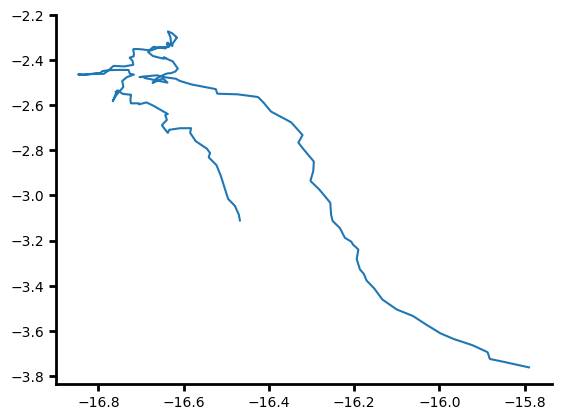

In [21]:
plt.plot(fictrac_x_mm,fictrac_y_mm)

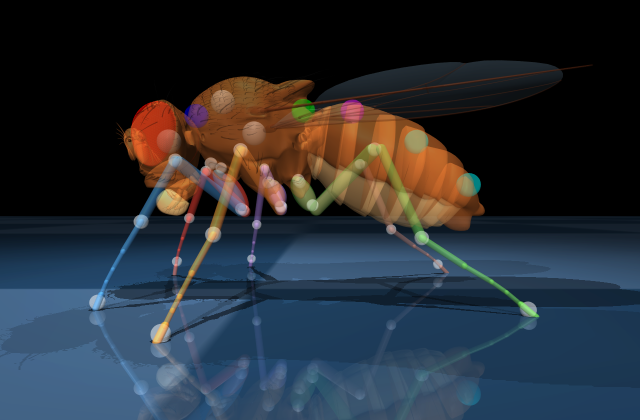

In [9]:
# xml_path = Path('/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast_amp.xml')
xml_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
spec = mujoco.MjSpec()
spec = spec.from_file(xml_path)
mj_model = spec.compile()
mj_data = mujoco.MjData(mj_model)

camera = 'back'

scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 1, 0, 0, 0, 0]
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = False
# scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
# scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
# scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
# scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,25,5)])
mujoco.mj_forward(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=640)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera='side', scene_option=scene_option)
pixels = renderer.render()
Image.fromarray(pixels)
# renderer.update_scene(mj_data, camera='side', scene_option=scene_option)
# pixels = renderer.render()
# Image.fromarray(pixels)
# im = Image.fromarray(pixels)
# im.save(fig_dir/f'example_mocap_{camera}.png',format='png',dpi=(300,300))
# Image.fromarray(pixels)
# im.save('example_mocap.png',format='png')
# media.show_image(pixels, title='amp_example.png',)

# Model Plotting

In [8]:
from PIL import Image

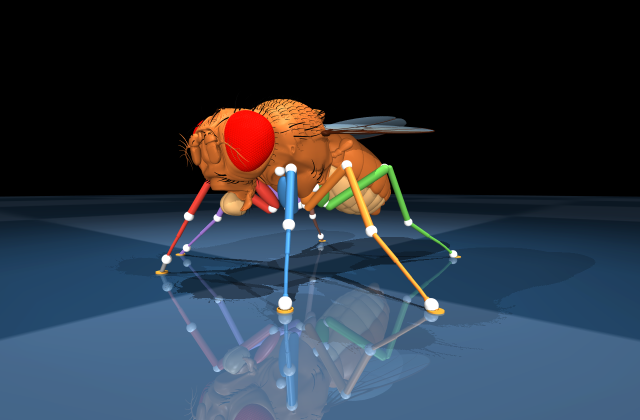

In [13]:
# xml_path = Path('/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_force_fast_amp.xml')
xml_path = '/home/eabe/Research/MyRepos/Brax-Rodent-Track/assets/fruitfly/fruitfly_viz_only.xml'
spec = mujoco.MjSpec()
spec = spec.from_file(xml_path)
mj_model = spec.compile()
mj_data = mujoco.MjData(mj_model)

camera = 'hero'

scene_option = mujoco.MjvOption()
scene_option.geomgroup[:] = [1, 1, 0, 0, 0, 0]
scene_option.sitegroup[:] = [1, 1, 1, 1, 1, 0]
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,25,5)])
mujoco.mj_forward(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=640)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=camera, scene_option=scene_option)
pixels = renderer.render()

im = Image.fromarray(pixels)
im.save(fig_dir/f'example_mocap_{camera}.png',format='png',dpi=(300,300))
Image.fromarray(pixels)
# im.save('example_mocap.png',format='png')
# media.show_image(pixels, title='amp_example.png',)

In [7]:
xml_path = task_path / 'task_viz.xml'
# xml_path = task_path.parent / 'fruitfly_force_pair.xml'
# xml_path = task_path.parent / 'fruitfly_force_seq.xml'
# xml_path = task_path.parent / 'fruitfly_force_fast.xml'

mj_model = mujoco.MjModel.from_xml_path(xml_path.as_posix())

mj_data = mujoco.MjData(mj_model)

mocap_names = [mj_model.site(i).name for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
mocap_id = [mj_model.site(i).id for i in range(mj_model.nsite) if 'mocap' in mj_model.site(i).name]
# for id in mocap_id:
#     mj_model.site(id).rgba = [0,1,0,1]
site_names = [mj_model.site(i).name for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
site_id = [mj_model.site(i).id for i in range(mj_model.nsite) if '-1' in mj_model.site(i).name]
for id in site_id:
    mj_model.site(id).rgba = [1,0,0,1]

# geom_names = [mj_model.geom(i).name for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]
# geom_ids = [mj_model.geom(i).id for i in range(mj_model.ngeom) if 'T3_left' in mj_model.geom(i).name]

# for id in geom_ids[5:]:
#     mj_model.geom(id).group = 4

camera_id = 0

scene_option = mujoco.MjvOption()
scene_option.sitegroup[:] = [1, 1, 1, 0, 1, 0]
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_ACTUATOR] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[mujoco.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[mujoco.mjtRndFlag.mjRND_FOG] = False
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_STATIC] = False

# mj_data.qpos = np.concatenate([qposes_stac[n] for n in range(0,2)])
# mj_data.qpos = qposes_stac[0]
mujoco.mj_kinematics(mj_model, mj_data)
renderer = mujoco.Renderer(mj_model, height=420, width=550)


# mj_data.mocap_pos = mod_frames[0].copy()
mujoco.mj_forward(mj_model, mj_data)

renderer.update_scene(mj_data, camera=camera_id, scene_option=scene_option)
pixels = renderer.render()
PIL.Image.fromarray(pixels)
# im = PIL.Image.fromarray(pixels)
# im.save(fig_path/'init_camera{}.png'.format(camera_id),format='png')

NameError: name 'task_path' is not defined